In [1]:
!nvidia-smi

Wed Apr  3 00:24:42 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.130                Driver Version: 384.130                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:05:00.0 Off |                  N/A |
| 28%   49C    P0    59W / 250W |      0MiB / 11170MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 27%   49C    P0    60W / 250W |      0MiB / 11172MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf
import numpy as np
import cv2
import os
import importlib
import time
import albumentations as albu

from utils import cpm_utils

# CONFIG

Config stuff

In [4]:
class FLAGS(object):
    """ """
    """
    General settings
    """
    input_size = (512, 512)
    heatmap_size = 64
    cpm_stages = 3
    joint_gaussian_variance = 1.0
    center_radius = 21
    num_of_joints = 8
    color_channel = 'RGB'
    normalize = True
    use_gpu = True
    gpu_id = 0


    """
    Demo settings
    """
    # 'MULTI': show multiple stage heatmaps
    # 'SINGLE': show last stage heatmap
    # 'Joint_HM': show last stage heatmap for each joint
    # 'image or video path': show detection on single image or video
    DEMO_TYPE = 'SINGLE'

    model_path = 'cpm_hand'
    cam_id = 0

    webcam_height = 480
    webcam_width = 640

    use_kalman = True
    kalman_noise = 0.03
    keypoints_order = ["TAIL_NOTCH",
                        "ADIPOSE_FIN",
                        "UPPER_LIP",
                        "ANAL_FIN",
                        "PELVIC_FIN",
                        "EYE",
                        "PECTORAL_FIN",
                        "DORSAL_FIN"]

    """
    Training settings
    """
    network_def = 'fish_test'
    train_img_dir = ''
    val_img_dir = ''
    bg_img_dir = ''
    pretrained_model = 'fish_test'
    batch_size = 8
    init_lr = 0.001
    lr_decay_rate = 0.5
    lr_decay_step = 10000
    augmentation = albu.Compose([# albu.RandomContrast(limit=0.3, p=0.3),
                                 # albu.RandomBrightness(limit=0.4, p=0.3),
                                 albu.Rotate(limit=10, p=1.0)], 
                                 p=1.0,
                                 keypoint_params={'format': 'xy'})
    
    epochs=100
#     augmentation_config = {'hue_shift_limit': (-5, 5),
#                            'sat_shift_limit': (-10, 10),
#                            'val_shift_limit': (-15, 15),
#                            'translation_limit': (-0.15, 0.15),
#                            'scale_limit': (-0.3, 0.5),
#                            'rotate_limit': (-90, 90)}
    hnm = True  # Make sure generate hnm files first
    do_cropping = True

    """
    For Freeze graphs
    """
    output_node_names = 'stage_3/mid_conv7/BiasAdd:0'

In [5]:
cpm_model = importlib.import_module('models.nets.' + FLAGS.network_def)

# MODEL CREATION

Creating a bunch of folder

In [6]:
from datetime import datetime

In [7]:
datenow = str(datetime.now()).split(".")[0].replace(" ","_").replace("-","_").replace(":","_")

In [8]:
base_dir = "/root/data/models/keypoints_detection/{}".format(datenow)

In [9]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

model_path_suffix = os.path.join(FLAGS.network_def,
                                 'input_{}_output_{}'.format(FLAGS.input_size, FLAGS.heatmap_size),
                                 'joints_{}'.format(FLAGS.num_of_joints),
                                 'stages_{}'.format(FLAGS.cpm_stages),
                                 'init_{}_rate_{}_step_{}'.format(FLAGS.init_lr, FLAGS.lr_decay_rate,
                                                                  FLAGS.lr_decay_step)
                                 )
model_save_dir = os.path.join(base_dir,
                              'weights')

Build network graph

In [10]:
model = cpm_model.CPM_Model(input_size=FLAGS.input_size,
                            heatmap_size=FLAGS.heatmap_size,
                            stages=FLAGS.cpm_stages,
                            joints=FLAGS.num_of_joints,
                            img_type=FLAGS.color_channel,
                            is_training=True)
model.build_loss(FLAGS.init_lr, FLAGS.lr_decay_rate, FLAGS.lr_decay_step, optimizer='RMSProp')
print('=====Model Build=====\n')

INFO:tensorflow:Summary name total loss train is illegal; using total_loss_train instead.
INFO:tensorflow:Summary name total loss eval is illegal; using total_loss_eval instead.
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
INFO:tensorflow:Summary name global learning rate is illegal; using global_learning_rate instead.
=====Model Build=====



# DATA GENERATOR

Creating data generator. 

In [11]:
import glob
import json
import random

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

from utils.utils import DataGenerator

Using TensorFlow backend.


In [12]:
random.seed(258)

Load all the gtsf session

In [13]:
annotations = glob.glob("/root/data/gtsf_phase_I/*/*_cogito_annotations.json")
print("Total number of gtsf sessions: {}".format(len(annotations)))

Total number of gtsf sessions: 14


Train - Val split. Let's split by experiment. Better practice

In [14]:
cutoff = int(len(annotations)*0.8)
random.shuffle(annotations)
train_files = annotations[:cutoff]
val_files = annotations[cutoff:]
print("Number of train files: {}".format(len(train_files)))
print("Number of validation files: {}".format(len(val_files)))

Number of train files: 11
Number of validation files: 3


In [15]:
train_annotations = []
for jpath in train_files:
    train_annotations += json.load(open(jpath))
print("Number of training data: {}".format(len(train_annotations)))
train_annotations= [ann for ann in train_annotations if ann["species"] == "salmon"]
print("Number of training data: {}".format(len(train_annotations)))

Number of training data: 939
Number of training data: 939


In [16]:
val_annotations = []
for jpath in val_files:
    val_annotations += json.load(open(jpath))
print("Number of validation data: {}".format(len(val_annotations)))
val_annotations = [ann for ann in val_annotations if ann["species"] == "salmon"]
print("Number of validation data: {}".format(len(val_annotations)))

Number of validation data: 152
Number of validation data: 144


In [17]:
# for ann in val_annotations + train_annotations:
#     local_path = os.path.join("/root/data/gtsf_phase_I/", 
#           "/".join(ann["Labeled Data"].split("/")[7:]))
#     if not os.path.isfile(local_path):
#         print(local_path)

Create generator

In [18]:
import os
import cv2
import numpy as np
from utils.utils import load_image_keypoints, DataGenerator

Test the function

In [19]:
im, kps = load_image_keypoints(np.random.choice(val_annotations), FLAGS)

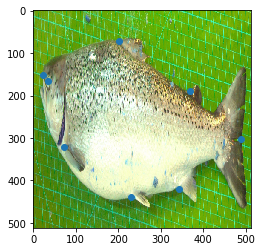

In [20]:
plt.imshow(im)
plt.scatter(kps[:, 0], kps[:, 1])
# for kpname in FLAGS.keypoints_order:
#     kpname = "_".join(kpname.replace(":", "").split()).upper()
#     plt.scatter(kps[kpname][0], kps[kpname][1])
plt.show()

Create generator itself

In [21]:
train_generator = DataGenerator(train_annotations, FLAGS)
val_generator = DataGenerator(train_annotations, FLAGS)

In [22]:
xb, yb, heatmaps = val_generator[4]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


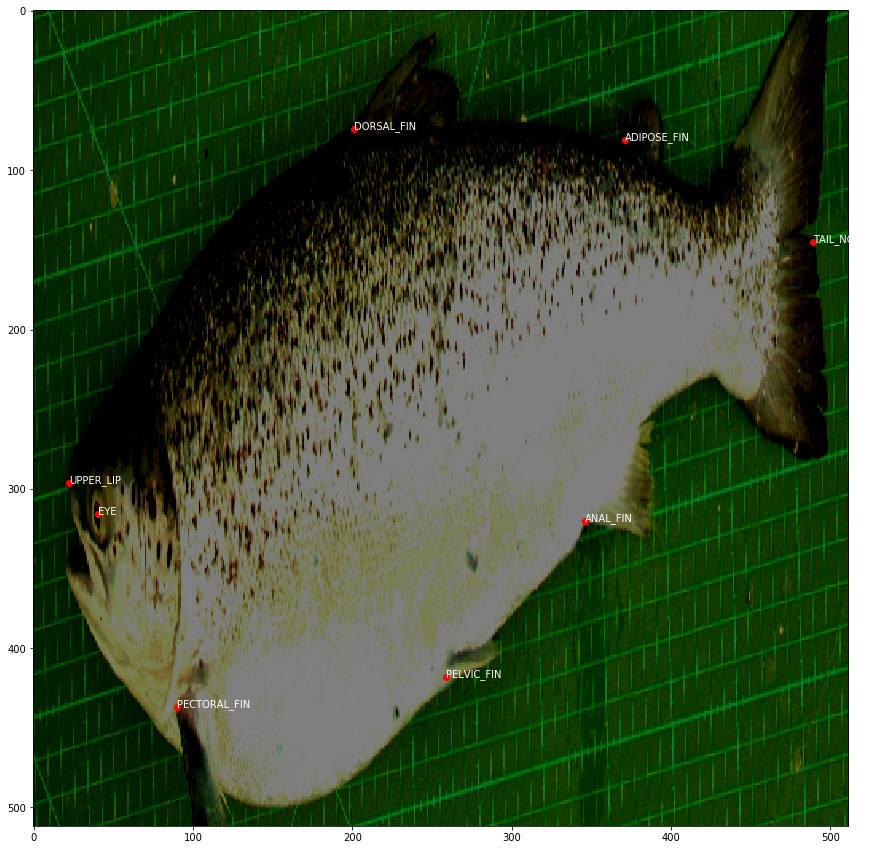

In [23]:
plt.figure(figsize=(15, 15))
plt.imshow(xb[1, ...])
i = 0
for kpp in yb[1]:
    plt.scatter(kpp[0], kpp[1], c="r")
    plt.text(kpp[0], kpp[1], FLAGS.keypoints_order[i], {"color": "w"})
    i += 1
plt.show()

Augmentations

In [24]:
# plt.imshow(im)
# plt.show()
# results = FLAGS.augmentation(image=im, keypoints=list(kps.values()))
# nkps = np.array(results['keypoints'])
# plt.imshow(results["image"])
# plt.scatter(nkps[:, 0], nkps[:, 1])
# plt.show()

# TRAINING

In [25]:
if not os.path.isdir(model_save_dir):
    os.makedirs(model_save_dir)

In [26]:
# save config
with open(os.path.join(base_dir, "config.json"), "w") as f:
    json.dump({k:v for (k,v) in FLAGS.__dict__.items() if k not in  ["__dict__", '__weakref__', 'augmentation']}, f)

In [27]:
def print_current_training_stats(global_step, cur_lr, stage_losses, total_loss, time_elapsed):
    stats = 'Step: {}/{} ----- Cur_lr: {:1.7f} ----- Time: {:>2.2f} sec.'.format(global_step, train_generator.__len__() * FLAGS.epochs,
                                                                                 cur_lr, time_elapsed)
    losses = ' | '.join(
        ['S{} loss: {:>7.2f}'.format(stage_num + 1, stage_losses[stage_num]) for stage_num in range(FLAGS.cpm_stages)])
    losses += ' | Total loss: {}'.format(total_loss)
    print(stats)
    print(losses + '\n')

In [ ]:
merged_summary = tf.summary.merge_all()
device_count = {'GPU': 1} if FLAGS.use_gpu else {'GPU': 0}

# cause fuck tensorboard
history = {"train_stages_loss":[],
           "train_total_loss": [],
           "val_total_loss": []}
with tf.Session(config=tf.ConfigProto(device_count=device_count,
                                      allow_soft_placement=True)) as sess:
#     # Create tensorboard
#     train_writer = tf.summary.FileWriter(train_log_save_dir, sess.graph)
#     test_writer = tf.summary.FileWriter(test_log_save_dir, sess.graph)
    
    # Create model saver
    saver = tf.train.Saver(max_to_keep=None) #max_to_keep=None)

    # Init all vars
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    # saver.restore(sess, '/root/data/models/keypoints_detection/2019_03_27_01_52_17/weights/fish_test-39')
    for epoch in range(FLAGS.epochs):
        print("Epoch {} starts".format(epoch))
        
        training_itr = 0
        
        while training_itr < train_generator.__len__():
            t1 = time.time()
            # load input + labels
            batch_x_np, _, batch_gt_heatmap_np = train_generator[training_itr]
            training_itr += 1
            
            # Forward and update weights
            stage_losses_np, total_loss_np, _, summaries, current_lr, \
            stage_heatmap_np, global_step = sess.run([model.stage_loss,
                                                  model.total_loss,
                                                  model.train_op,
                                                  merged_summary,
                                                  model.cur_lr,
                                                  model.stage_heatmap,
                                                  model.global_step
                                                  ],
                                                 feed_dict={model.input_images: batch_x_np,
                                                            model.gt_hmap_placeholder: batch_gt_heatmap_np})
            
            history["train_stages_loss"].append([float(s) for s in stage_losses_np])
            history["train_total_loss"].append(float(total_loss_np))
            # Show training info
            print_current_training_stats(global_step, current_lr, stage_losses_np, total_loss_np, time.time() - t1)
            
            # Write logs
            # train_writer.add_summary(summaries, epoch*training_itr)
        
        # shuffle on epoch end
        train_generator.on_epoch_end()
        
        saver.save(sess=sess, save_path=model_save_dir + '/' + FLAGS.network_def.split('.py')[0], 
                   global_step=epoch)
        print('\nModel checkpoint saved...\n')
        
        # now validation stuff
        mean_val_loss = 0
        val_itr = 0
        while val_itr < val_generator.__len__():
            # load input + labels
            batch_x_np, _, batch_gt_heatmap_np = val_generator[val_itr]
            val_itr += 1

            val_total_loss, summaries = sess.run([model.total_loss, merged_summary],
                                                 feed_dict={model.input_images: batch_x_np,
                                                               model.gt_hmap_placeholder: batch_gt_heatmap_np})
            mean_val_loss += val_total_loss
        val_mean_loss = mean_val_loss / val_generator.__len__()
        history["val_total_loss"].append(float(val_mean_loss))
        print('\nValidation loss: {:>7.2f}\n'.format(val_mean_loss))
        # test_writer.add_summary(summaries, global_step)
        # save history
        with open(os.path.join(base_dir, "history.json"), "w") as f:
            json.dump(history, f)
        
        print("#"*100)

Epoch 0 starts
Step: 1/11700 ----- Cur_lr: 0.0010000 ----- Time: 4.75 sec.
S1 loss: 2022.87 | S2 loss: 2023.54 | S3 loss: 2023.84 | Total loss: 6070.251953125

Step: 2/11700 ----- Cur_lr: 0.0009999 ----- Time: 2.09 sec.
S1 loss: 1728.01 | S2 loss: 1877.91 | S3 loss: 1868.34 | Total loss: 5474.2685546875

Step: 3/11700 ----- Cur_lr: 0.0009999 ----- Time: 2.10 sec.
S1 loss: 1186469.50 | S2 loss: 3761468672.00 | S3 loss: 1820366471168.00 | Total loss: 1824129155072.0

Step: 4/11700 ----- Cur_lr: 0.0009998 ----- Time: 2.04 sec.
S1 loss: 917669.88 | S2 loss: 170123427840.00 | S3 loss: 2261699176431616.00 | Total loss: 2261869364510720.0

Step: 5/11700 ----- Cur_lr: 0.0009997 ----- Time: 2.08 sec.
S1 loss: 1967.71 | S2 loss: 2350.80 | S3 loss: 4189.24 | Total loss: 8507.75

Step: 6/11700 ----- Cur_lr: 0.0009997 ----- Time: 2.07 sec.
S1 loss: 1993.09 | S2 loss: 2016.93 | S3 loss: 1813.22 | Total loss: 5823.23974609375

Step: 7/11700 ----- Cur_lr: 0.0009996 ----- Time: 2.07 sec.
S1 loss: 1900.

Step: 57/11700 ----- Cur_lr: 0.0009961 ----- Time: 2.09 sec.
S1 loss: 1048.27 | S2 loss:  881.92 | S3 loss:  344.19 | Total loss: 2274.3818359375

Step: 58/11700 ----- Cur_lr: 0.0009961 ----- Time: 2.07 sec.
S1 loss:  849.74 | S2 loss:  686.10 | S3 loss:  411.38 | Total loss: 1947.23193359375

Step: 59/11700 ----- Cur_lr: 0.0009960 ----- Time: 2.07 sec.
S1 loss:  822.83 | S2 loss: 1037.10 | S3 loss:  369.16 | Total loss: 2229.083984375

Step: 60/11700 ----- Cur_lr: 0.0009959 ----- Time: 2.06 sec.
S1 loss:  970.57 | S2 loss:  513.68 | S3 loss:  930.74 | Total loss: 2415.00048828125

Step: 61/11700 ----- Cur_lr: 0.0009958 ----- Time: 2.06 sec.
S1 loss:  398.51 | S2 loss: 1778.94 | S3 loss:  507.54 | Total loss: 2684.98193359375

Step: 62/11700 ----- Cur_lr: 0.0009958 ----- Time: 2.12 sec.
S1 loss: 1113.94 | S2 loss: 1585.66 | S3 loss: 1248.15 | Total loss: 3947.7548828125

Step: 63/11700 ----- Cur_lr: 0.0009957 ----- Time: 2.08 sec.
S1 loss:  937.76 | S2 loss: 1470.46 | S3 loss:  704.51 

Step: 113/11700 ----- Cur_lr: 0.0009923 ----- Time: 2.11 sec.
S1 loss: 1409.14 | S2 loss:  894.15 | S3 loss: 1658.34 | Total loss: 3961.625732421875

Step: 114/11700 ----- Cur_lr: 0.0009922 ----- Time: 2.11 sec.
S1 loss: 1355.57 | S2 loss:  396.13 | S3 loss: 1618.87 | Total loss: 3370.561767578125

Step: 115/11700 ----- Cur_lr: 0.0009921 ----- Time: 2.13 sec.
S1 loss: 1273.19 | S2 loss: 3105.45 | S3 loss: 1142.77 | Total loss: 5521.41748046875

Step: 116/11700 ----- Cur_lr: 0.0009921 ----- Time: 2.09 sec.
S1 loss: 1481.45 | S2 loss: 1505.24 | S3 loss: 1450.86 | Total loss: 4437.5439453125

Step: 117/11700 ----- Cur_lr: 0.0009920 ----- Time: 2.08 sec.
S1 loss: 1417.84 | S2 loss: 1471.70 | S3 loss:  981.12 | Total loss: 3870.65380859375

INFO:tensorflow:/root/data/models/keypoints_detection/2019_04_03_00_24_44/weights/fish_test-0 is not in all_model_checkpoint_paths. Manually adding it.

Model checkpoint saved...


Validation loss: 3313.92

###############################################

Step: 166/11700 ----- Cur_lr: 0.0009886 ----- Time: 2.06 sec.
S1 loss:  687.79 | S2 loss: 1133.58 | S3 loss:  408.70 | Total loss: 2230.0712890625

Step: 167/11700 ----- Cur_lr: 0.0009886 ----- Time: 2.09 sec.
S1 loss:  493.86 | S2 loss:  725.69 | S3 loss: 5667.14 | Total loss: 6886.69580078125

Step: 168/11700 ----- Cur_lr: 0.0009885 ----- Time: 2.08 sec.
S1 loss:  899.98 | S2 loss:  307.29 | S3 loss: 1427.28 | Total loss: 2634.554931640625

Step: 169/11700 ----- Cur_lr: 0.0009884 ----- Time: 2.03 sec.
S1 loss:  772.00 | S2 loss:  361.57 | S3 loss: 1132.65 | Total loss: 2266.22314453125

Step: 170/11700 ----- Cur_lr: 0.0009884 ----- Time: 2.06 sec.
S1 loss:  785.32 | S2 loss:  263.00 | S3 loss: 1082.55 | Total loss: 2130.8681640625

Step: 171/11700 ----- Cur_lr: 0.0009883 ----- Time: 2.07 sec.
S1 loss:  579.11 | S2 loss:  782.46 | S3 loss:  787.39 | Total loss: 2148.96337890625

Step: 172/11700 ----- Cur_lr: 0.0009882 ----- Time: 2.10 sec.
S1 loss:  848.37 | S2 loss:  686.40 | S3 loss

Step: 222/11700 ----- Cur_lr: 0.0009848 ----- Time: 2.06 sec.
S1 loss: 1095.78 | S2 loss:  903.94 | S3 loss:  856.98 | Total loss: 2856.705078125

Step: 223/11700 ----- Cur_lr: 0.0009847 ----- Time: 2.05 sec.
S1 loss: 1065.70 | S2 loss:  197.88 | S3 loss:  521.12 | Total loss: 1784.6912841796875

Step: 224/11700 ----- Cur_lr: 0.0009847 ----- Time: 2.06 sec.
S1 loss:  975.64 | S2 loss: 1369.03 | S3 loss:  444.77 | Total loss: 2789.43603515625

Step: 225/11700 ----- Cur_lr: 0.0009846 ----- Time: 2.10 sec.
S1 loss: 1162.41 | S2 loss: 1413.85 | S3 loss: 1041.69 | Total loss: 3617.943359375

Step: 226/11700 ----- Cur_lr: 0.0009845 ----- Time: 2.05 sec.
S1 loss: 1137.28 | S2 loss: 1282.99 | S3 loss:  902.02 | Total loss: 3322.292724609375

Step: 227/11700 ----- Cur_lr: 0.0009845 ----- Time: 2.09 sec.
S1 loss: 1099.24 | S2 loss: 1132.66 | S3 loss:  487.56 | Total loss: 2719.47119140625

Step: 228/11700 ----- Cur_lr: 0.0009844 ----- Time: 2.06 sec.
S1 loss: 1052.18 | S2 loss:  847.72 | S3 loss

Step: 275/11700 ----- Cur_lr: 0.0009812 ----- Time: 2.06 sec.
S1 loss:  275.60 | S2 loss:  255.93 | S3 loss: 1042.58 | Total loss: 1574.1075439453125

Step: 276/11700 ----- Cur_lr: 0.0009811 ----- Time: 2.08 sec.
S1 loss:  742.85 | S2 loss:  678.71 | S3 loss: 1009.06 | Total loss: 2430.623046875

Step: 277/11700 ----- Cur_lr: 0.0009811 ----- Time: 2.09 sec.
S1 loss:  546.97 | S2 loss:  443.22 | S3 loss:  950.17 | Total loss: 1940.3680419921875

Step: 278/11700 ----- Cur_lr: 0.0009810 ----- Time: 2.06 sec.
S1 loss:  207.65 | S2 loss:  677.22 | S3 loss:  798.86 | Total loss: 1683.7298583984375

Step: 279/11700 ----- Cur_lr: 0.0009809 ----- Time: 2.06 sec.
S1 loss:  532.25 | S2 loss:  830.22 | S3 loss:  741.99 | Total loss: 2104.455078125

Step: 280/11700 ----- Cur_lr: 0.0009808 ----- Time: 2.06 sec.
S1 loss:  356.19 | S2 loss:  436.51 | S3 loss:  544.97 | Total loss: 1337.669921875

Step: 281/11700 ----- Cur_lr: 0.0009808 ----- Time: 2.04 sec.
S1 loss:   91.20 | S2 loss:  578.18 | S3 los

Step: 330/11700 ----- Cur_lr: 0.0009775 ----- Time: 2.10 sec.
S1 loss:  129.07 | S2 loss:  182.50 | S3 loss:  290.88 | Total loss: 602.451171875

Step: 331/11700 ----- Cur_lr: 0.0009774 ----- Time: 2.05 sec.
S1 loss:  144.85 | S2 loss:  451.19 | S3 loss:  381.83 | Total loss: 977.86328125

Step: 332/11700 ----- Cur_lr: 0.0009773 ----- Time: 2.02 sec.
S1 loss:  160.97 | S2 loss:  211.21 | S3 loss:  238.72 | Total loss: 610.901123046875

Step: 333/11700 ----- Cur_lr: 0.0009773 ----- Time: 2.04 sec.
S1 loss:  238.02 | S2 loss:  561.45 | S3 loss:  238.68 | Total loss: 1038.155517578125

Step: 334/11700 ----- Cur_lr: 0.0009772 ----- Time: 2.07 sec.
S1 loss:  103.54 | S2 loss:  134.98 | S3 loss:   74.21 | Total loss: 312.7278747558594

Step: 335/11700 ----- Cur_lr: 0.0009771 ----- Time: 2.07 sec.
S1 loss:   92.32 | S2 loss:  305.18 | S3 loss:   71.87 | Total loss: 469.3728332519531

Step: 336/11700 ----- Cur_lr: 0.0009770 ----- Time: 2.03 sec.
S1 loss:  138.01 | S2 loss:  813.06 | S3 loss: 1

Step: 383/11700 ----- Cur_lr: 0.0009739 ----- Time: 2.09 sec.
S1 loss:  279.67 | S2 loss:  435.75 | S3 loss:  243.40 | Total loss: 958.8173217773438

Step: 384/11700 ----- Cur_lr: 0.0009738 ----- Time: 2.07 sec.
S1 loss:  196.96 | S2 loss:  162.19 | S3 loss:  180.95 | Total loss: 540.092041015625

Step: 385/11700 ----- Cur_lr: 0.0009737 ----- Time: 2.10 sec.
S1 loss:  156.36 | S2 loss:  381.53 | S3 loss:  110.48 | Total loss: 648.3705444335938

Step: 386/11700 ----- Cur_lr: 0.0009737 ----- Time: 2.06 sec.
S1 loss:  162.31 | S2 loss:  111.56 | S3 loss:   49.68 | Total loss: 323.5596923828125

Step: 387/11700 ----- Cur_lr: 0.0009736 ----- Time: 2.13 sec.
S1 loss:  173.69 | S2 loss:  160.77 | S3 loss:   70.92 | Total loss: 405.37481689453125

Step: 388/11700 ----- Cur_lr: 0.0009735 ----- Time: 2.09 sec.
S1 loss:  146.09 | S2 loss:  455.87 | S3 loss:  610.74 | Total loss: 1212.692138671875

Step: 389/11700 ----- Cur_lr: 0.0009735 ----- Time: 2.03 sec.
S1 loss:  304.36 | S2 loss:  535.95 | 

Step: 438/11700 ----- Cur_lr: 0.0009702 ----- Time: 2.10 sec.
S1 loss:   46.64 | S2 loss:   80.25 | S3 loss:   30.62 | Total loss: 157.50926208496094

Step: 439/11700 ----- Cur_lr: 0.0009701 ----- Time: 2.16 sec.
S1 loss:   52.22 | S2 loss:  145.44 | S3 loss:   40.43 | Total loss: 238.0865478515625

Step: 440/11700 ----- Cur_lr: 0.0009700 ----- Time: 2.05 sec.
S1 loss:   47.59 | S2 loss:   89.37 | S3 loss:   31.34 | Total loss: 168.3027801513672

Step: 441/11700 ----- Cur_lr: 0.0009700 ----- Time: 2.10 sec.
S1 loss:   56.45 | S2 loss:  167.26 | S3 loss:   43.14 | Total loss: 266.8481750488281

Step: 442/11700 ----- Cur_lr: 0.0009699 ----- Time: 2.02 sec.
S1 loss:   56.14 | S2 loss:   68.44 | S3 loss:   26.50 | Total loss: 151.0789031982422

Step: 443/11700 ----- Cur_lr: 0.0009698 ----- Time: 2.08 sec.
S1 loss:   73.63 | S2 loss:   89.58 | S3 loss:   28.02 | Total loss: 191.22894287109375

Step: 444/11700 ----- Cur_lr: 0.0009698 ----- Time: 2.13 sec.
S1 loss:   54.50 | S2 loss:   66.09 

Step: 491/11700 ----- Cur_lr: 0.0009666 ----- Time: 2.06 sec.
S1 loss:  654.28 | S2 loss: 1083.11 | S3 loss:   26.46 | Total loss: 1763.8533935546875

Step: 492/11700 ----- Cur_lr: 0.0009665 ----- Time: 2.02 sec.
S1 loss:  563.59 | S2 loss:  921.02 | S3 loss:   26.07 | Total loss: 1510.683837890625

Step: 493/11700 ----- Cur_lr: 0.0009665 ----- Time: 2.05 sec.
S1 loss:  433.53 | S2 loss:  477.81 | S3 loss:   26.50 | Total loss: 937.8381958007812

Step: 494/11700 ----- Cur_lr: 0.0009664 ----- Time: 2.09 sec.
S1 loss:  270.27 | S2 loss: 2473.21 | S3 loss:   76.21 | Total loss: 2819.696533203125

Step: 495/11700 ----- Cur_lr: 0.0009663 ----- Time: 2.06 sec.
S1 loss:  695.45 | S2 loss: 1106.21 | S3 loss:   41.06 | Total loss: 1842.72216796875

Step: 496/11700 ----- Cur_lr: 0.0009663 ----- Time: 2.11 sec.
S1 loss:  632.59 | S2 loss: 1053.05 | S3 loss:   31.69 | Total loss: 1717.3355712890625

Step: 497/11700 ----- Cur_lr: 0.0009662 ----- Time: 2.06 sec.
S1 loss:  571.61 | S2 loss:  957.40 |

Step: 546/11700 ----- Cur_lr: 0.0009629 ----- Time: 2.04 sec.
S1 loss:  116.10 | S2 loss:  582.71 | S3 loss:   26.85 | Total loss: 725.6588134765625

Step: 547/11700 ----- Cur_lr: 0.0009629 ----- Time: 2.06 sec.
S1 loss:  120.40 | S2 loss:  451.90 | S3 loss:   27.39 | Total loss: 599.6932983398438

Step: 548/11700 ----- Cur_lr: 0.0009628 ----- Time: 2.08 sec.
S1 loss:  107.05 | S2 loss:  312.66 | S3 loss:   25.11 | Total loss: 444.8222351074219

Step: 549/11700 ----- Cur_lr: 0.0009627 ----- Time: 2.08 sec.
S1 loss:   91.75 | S2 loss:  447.32 | S3 loss:   24.86 | Total loss: 563.92626953125

Step: 550/11700 ----- Cur_lr: 0.0009627 ----- Time: 2.11 sec.
S1 loss:   75.72 | S2 loss:  163.72 | S3 loss:   24.96 | Total loss: 264.4003601074219

Step: 551/11700 ----- Cur_lr: 0.0009626 ----- Time: 2.08 sec.
S1 loss:   51.79 | S2 loss:  164.05 | S3 loss:   25.15 | Total loss: 240.9894256591797

Step: 552/11700 ----- Cur_lr: 0.0009625 ----- Time: 2.02 sec.
S1 loss:  119.64 | S2 loss:  351.54 | S3

Step: 599/11700 ----- Cur_lr: 0.0009594 ----- Time: 2.07 sec.
S1 loss:  101.64 | S2 loss:   96.94 | S3 loss:   26.29 | Total loss: 224.8689422607422

Step: 600/11700 ----- Cur_lr: 0.0009593 ----- Time: 2.03 sec.
S1 loss:   89.70 | S2 loss:  125.11 | S3 loss:   25.97 | Total loss: 240.78057861328125

Step: 601/11700 ----- Cur_lr: 0.0009593 ----- Time: 2.11 sec.
S1 loss:   63.44 | S2 loss:  291.15 | S3 loss:   25.55 | Total loss: 380.1458740234375

Step: 602/11700 ----- Cur_lr: 0.0009592 ----- Time: 2.06 sec.
S1 loss:   86.74 | S2 loss:  281.95 | S3 loss:   25.80 | Total loss: 394.4885559082031

Step: 603/11700 ----- Cur_lr: 0.0009591 ----- Time: 2.07 sec.
S1 loss:   64.16 | S2 loss:  221.86 | S3 loss:   26.36 | Total loss: 312.38275146484375

Step: 604/11700 ----- Cur_lr: 0.0009591 ----- Time: 2.06 sec.
S1 loss:   47.88 | S2 loss:  151.62 | S3 loss:   27.05 | Total loss: 226.54913330078125

Step: 605/11700 ----- Cur_lr: 0.0009590 ----- Time: 2.06 sec.
S1 loss:   38.64 | S2 loss:   83.59

Step: 654/11700 ----- Cur_lr: 0.0009557 ----- Time: 2.06 sec.
S1 loss:   32.50 | S2 loss:   35.46 | S3 loss:   25.79 | Total loss: 93.74627685546875

Step: 655/11700 ----- Cur_lr: 0.0009557 ----- Time: 2.07 sec.
S1 loss:   33.98 | S2 loss:   42.64 | S3 loss:   26.03 | Total loss: 102.64335632324219

Step: 656/11700 ----- Cur_lr: 0.0009556 ----- Time: 2.05 sec.
S1 loss:   32.29 | S2 loss:   31.26 | S3 loss:   31.37 | Total loss: 94.91744995117188

Step: 657/11700 ----- Cur_lr: 0.0009555 ----- Time: 2.06 sec.
S1 loss:   34.18 | S2 loss:   37.88 | S3 loss:   32.78 | Total loss: 104.84249877929688

Step: 658/11700 ----- Cur_lr: 0.0009555 ----- Time: 2.10 sec.
S1 loss:   32.04 | S2 loss:   31.63 | S3 loss:   26.41 | Total loss: 90.0894546508789

Step: 659/11700 ----- Cur_lr: 0.0009554 ----- Time: 2.07 sec.
S1 loss:   34.09 | S2 loss:   38.42 | S3 loss:   25.78 | Total loss: 98.28961181640625

Step: 660/11700 ----- Cur_lr: 0.0009553 ----- Time: 2.07 sec.
S1 loss:   33.20 | S2 loss:   33.79 |

Step: 707/11700 ----- Cur_lr: 0.0009522 ----- Time: 2.04 sec.
S1 loss:   26.31 | S2 loss:   26.14 | S3 loss:   25.95 | Total loss: 78.39990234375

Step: 708/11700 ----- Cur_lr: 0.0009522 ----- Time: 2.08 sec.
S1 loss:   26.39 | S2 loss:   26.18 | S3 loss:   26.39 | Total loss: 78.95601654052734

Step: 709/11700 ----- Cur_lr: 0.0009521 ----- Time: 2.05 sec.
S1 loss:   26.43 | S2 loss:   25.37 | S3 loss:   27.79 | Total loss: 79.5866928100586

Step: 710/11700 ----- Cur_lr: 0.0009520 ----- Time: 2.07 sec.
S1 loss:   27.06 | S2 loss:   25.41 | S3 loss:   26.80 | Total loss: 79.265869140625

Step: 711/11700 ----- Cur_lr: 0.0009520 ----- Time: 2.09 sec.
S1 loss:   28.41 | S2 loss:   25.37 | S3 loss:   26.19 | Total loss: 79.9686050415039

Step: 712/11700 ----- Cur_lr: 0.0009519 ----- Time: 2.02 sec.
S1 loss:   29.17 | S2 loss:   25.27 | S3 loss:   25.69 | Total loss: 80.12425231933594

Step: 713/11700 ----- Cur_lr: 0.0009518 ----- Time: 2.10 sec.
S1 loss:   31.45 | S2 loss:   25.23 | S3 loss

Step: 762/11700 ----- Cur_lr: 0.0009486 ----- Time: 2.05 sec.
S1 loss:   31.36 | S2 loss:   25.79 | S3 loss:   26.30 | Total loss: 83.43960571289062

Step: 763/11700 ----- Cur_lr: 0.0009486 ----- Time: 2.04 sec.
S1 loss:   33.95 | S2 loss:   26.10 | S3 loss:   26.69 | Total loss: 86.74140167236328

Step: 764/11700 ----- Cur_lr: 0.0009485 ----- Time: 2.03 sec.
S1 loss:   31.99 | S2 loss:   25.95 | S3 loss:   26.13 | Total loss: 84.07508850097656

Step: 765/11700 ----- Cur_lr: 0.0009484 ----- Time: 2.06 sec.
S1 loss:   33.03 | S2 loss:   26.34 | S3 loss:   26.00 | Total loss: 85.36909484863281

Step: 766/11700 ----- Cur_lr: 0.0009484 ----- Time: 2.07 sec.
S1 loss:   31.22 | S2 loss:   26.87 | S3 loss:   25.76 | Total loss: 83.85303497314453

Step: 767/11700 ----- Cur_lr: 0.0009483 ----- Time: 2.00 sec.
S1 loss:   32.95 | S2 loss:   28.83 | S3 loss:   29.40 | Total loss: 91.1790771484375

Step: 768/11700 ----- Cur_lr: 0.0009482 ----- Time: 2.06 sec.
S1 loss:   31.62 | S2 loss:   28.62 | S

Step: 817/11700 ----- Cur_lr: 0.0009450 ----- Time: 2.08 sec.
S1 loss:   30.60 | S2 loss:   26.11 | S3 loss:   26.16 | Total loss: 82.87564086914062

Step: 818/11700 ----- Cur_lr: 0.0009449 ----- Time: 2.01 sec.
S1 loss:   29.66 | S2 loss:   25.62 | S3 loss:   26.37 | Total loss: 81.64466857910156

Step: 819/11700 ----- Cur_lr: 0.0009449 ----- Time: 2.05 sec.
S1 loss:   30.42 | S2 loss:   25.53 | S3 loss:   25.58 | Total loss: 81.52853393554688

INFO:tensorflow:/root/data/models/keypoints_detection/2019_04_03_00_24_44/weights/fish_test-6 is not in all_model_checkpoint_paths. Manually adding it.

Model checkpoint saved...


Validation loss:   80.20

####################################################################################################
Epoch 7 starts
Step: 820/11700 ----- Cur_lr: 0.0009448 ----- Time: 2.02 sec.
S1 loss:   29.28 | S2 loss:   25.42 | S3 loss:   25.42 | Total loss: 80.1238784790039

Step: 821/11700 ----- Cur_lr: 0.0009447 ----- Time: 2.06 sec.
S1 loss:   30.27

Step: 870/11700 ----- Cur_lr: 0.0009415 ----- Time: 2.07 sec.
S1 loss:   27.00 | S2 loss:   25.38 | S3 loss:   25.50 | Total loss: 77.87611389160156

Step: 871/11700 ----- Cur_lr: 0.0009415 ----- Time: 2.06 sec.
S1 loss:   26.75 | S2 loss:   25.38 | S3 loss:   25.46 | Total loss: 77.58723449707031

Step: 872/11700 ----- Cur_lr: 0.0009414 ----- Time: 2.03 sec.
S1 loss:   27.34 | S2 loss:   25.50 | S3 loss:   25.64 | Total loss: 78.47550201416016

Step: 873/11700 ----- Cur_lr: 0.0009413 ----- Time: 2.10 sec.
S1 loss:   29.28 | S2 loss:   25.34 | S3 loss:   25.93 | Total loss: 80.560302734375

Step: 874/11700 ----- Cur_lr: 0.0009413 ----- Time: 2.08 sec.
S1 loss:   29.63 | S2 loss:   25.18 | S3 loss:   26.01 | Total loss: 80.82600402832031

Step: 875/11700 ----- Cur_lr: 0.0009412 ----- Time: 2.04 sec.
S1 loss:   31.25 | S2 loss:   25.57 | S3 loss:   26.70 | Total loss: 83.5194091796875

Step: 876/11700 ----- Cur_lr: 0.0009412 ----- Time: 2.08 sec.
S1 loss:   30.70 | S2 loss:   26.16 | S3 

Step: 925/11700 ----- Cur_lr: 0.0009380 ----- Time: 2.06 sec.
S1 loss:   28.31 | S2 loss:   24.99 | S3 loss:   26.30 | Total loss: 79.59546661376953

Step: 926/11700 ----- Cur_lr: 0.0009379 ----- Time: 2.09 sec.
S1 loss:   27.73 | S2 loss:   25.32 | S3 loss:   26.55 | Total loss: 79.59733581542969

Step: 927/11700 ----- Cur_lr: 0.0009378 ----- Time: 2.02 sec.
S1 loss:   28.12 | S2 loss:   25.57 | S3 loss:   26.55 | Total loss: 80.23529052734375

Step: 928/11700 ----- Cur_lr: 0.0009378 ----- Time: 2.06 sec.
S1 loss:   27.94 | S2 loss:   25.61 | S3 loss:   26.22 | Total loss: 79.77286529541016

Step: 929/11700 ----- Cur_lr: 0.0009377 ----- Time: 2.04 sec.
S1 loss:   29.44 | S2 loss:   25.70 | S3 loss:   26.19 | Total loss: 81.33338928222656

Step: 930/11700 ----- Cur_lr: 0.0009376 ----- Time: 2.05 sec.
S1 loss:   28.75 | S2 loss:   25.48 | S3 loss:   25.94 | Total loss: 80.16456604003906

Step: 931/11700 ----- Cur_lr: 0.0009376 ----- Time: 2.08 sec.
S1 loss:   28.79 | S2 loss:   25.43 | 

Step: 978/11700 ----- Cur_lr: 0.0009345 ----- Time: 2.05 sec.
S1 loss:   31.16 | S2 loss:   25.62 | S3 loss:   26.48 | Total loss: 83.25245666503906

Step: 979/11700 ----- Cur_lr: 0.0009345 ----- Time: 2.11 sec.
S1 loss:   29.48 | S2 loss:   25.22 | S3 loss:   26.12 | Total loss: 80.82076263427734

Step: 980/11700 ----- Cur_lr: 0.0009344 ----- Time: 2.04 sec.
S1 loss:   27.13 | S2 loss:   24.71 | S3 loss:   25.80 | Total loss: 77.6345443725586

Step: 981/11700 ----- Cur_lr: 0.0009343 ----- Time: 2.05 sec.
S1 loss:   26.75 | S2 loss:   24.72 | S3 loss:   25.82 | Total loss: 77.29196166992188

Step: 982/11700 ----- Cur_lr: 0.0009343 ----- Time: 2.06 sec.
S1 loss:   26.30 | S2 loss:   24.71 | S3 loss:   25.61 | Total loss: 76.62980651855469

Step: 983/11700 ----- Cur_lr: 0.0009342 ----- Time: 2.09 sec.
S1 loss:   26.65 | S2 loss:   24.91 | S3 loss:   25.73 | Total loss: 77.28842163085938

Step: 984/11700 ----- Cur_lr: 0.0009341 ----- Time: 2.09 sec.
S1 loss:   26.57 | S2 loss:   24.99 | S

Step: 1033/11700 ----- Cur_lr: 0.0009310 ----- Time: 2.05 sec.
S1 loss:   25.46 | S2 loss:   25.70 | S3 loss:   26.53 | Total loss: 77.68517303466797

Step: 1034/11700 ----- Cur_lr: 0.0009309 ----- Time: 2.08 sec.
S1 loss:   25.55 | S2 loss:   25.25 | S3 loss:   25.75 | Total loss: 76.54940795898438

Step: 1035/11700 ----- Cur_lr: 0.0009308 ----- Time: 2.09 sec.
S1 loss:   25.62 | S2 loss:   25.21 | S3 loss:   25.89 | Total loss: 76.71900939941406

Step: 1036/11700 ----- Cur_lr: 0.0009308 ----- Time: 2.07 sec.
S1 loss:   25.40 | S2 loss:   24.91 | S3 loss:   25.40 | Total loss: 75.71723175048828

Step: 1037/11700 ----- Cur_lr: 0.0009307 ----- Time: 2.06 sec.
S1 loss:   25.60 | S2 loss:   25.44 | S3 loss:   30.62 | Total loss: 81.65444946289062

Step: 1038/11700 ----- Cur_lr: 0.0009306 ----- Time: 2.08 sec.
S1 loss:   25.52 | S2 loss:   25.37 | S3 loss:   30.00 | Total loss: 80.89634704589844

Step: 1039/11700 ----- Cur_lr: 0.0009306 ----- Time: 2.07 sec.
S1 loss:   25.58 | S2 loss:   2

Step: 1086/11700 ----- Cur_lr: 0.0009276 ----- Time: 2.10 sec.
S1 loss:   27.20 | S2 loss:   26.30 | S3 loss:   25.76 | Total loss: 79.25840759277344

Step: 1087/11700 ----- Cur_lr: 0.0009275 ----- Time: 2.10 sec.
S1 loss:   27.27 | S2 loss:   26.92 | S3 loss:   25.93 | Total loss: 80.12321472167969

Step: 1088/11700 ----- Cur_lr: 0.0009274 ----- Time: 2.12 sec.
S1 loss:   27.96 | S2 loss:   26.10 | S3 loss:   25.88 | Total loss: 79.93815612792969

Step: 1089/11700 ----- Cur_lr: 0.0009274 ----- Time: 2.06 sec.
S1 loss:   27.35 | S2 loss:   25.56 | S3 loss:   25.69 | Total loss: 78.59723663330078

Step: 1090/11700 ----- Cur_lr: 0.0009273 ----- Time: 2.07 sec.
S1 loss:   28.03 | S2 loss:   25.86 | S3 loss:   26.20 | Total loss: 80.08576965332031

Step: 1091/11700 ----- Cur_lr: 0.0009272 ----- Time: 2.05 sec.
S1 loss:   27.29 | S2 loss:   25.87 | S3 loss:   26.08 | Total loss: 79.237548828125

Step: 1092/11700 ----- Cur_lr: 0.0009272 ----- Time: 2.04 sec.
S1 loss:   27.28 | S2 loss:   25.

Step: 1141/11700 ----- Cur_lr: 0.0009240 ----- Time: 2.06 sec.
S1 loss:   25.44 | S2 loss:   24.95 | S3 loss:   25.48 | Total loss: 75.86843872070312

Step: 1142/11700 ----- Cur_lr: 0.0009240 ----- Time: 2.06 sec.
S1 loss:   26.21 | S2 loss:   25.55 | S3 loss:   26.19 | Total loss: 77.95036315917969

Step: 1143/11700 ----- Cur_lr: 0.0009239 ----- Time: 2.04 sec.
S1 loss:   25.95 | S2 loss:   24.97 | S3 loss:   25.86 | Total loss: 76.77668762207031

Step: 1144/11700 ----- Cur_lr: 0.0009238 ----- Time: 2.07 sec.
S1 loss:   26.68 | S2 loss:   25.31 | S3 loss:   26.39 | Total loss: 78.37403869628906

Step: 1145/11700 ----- Cur_lr: 0.0009238 ----- Time: 2.04 sec.
S1 loss:   26.98 | S2 loss:   25.14 | S3 loss:   26.32 | Total loss: 78.4342041015625

Step: 1146/11700 ----- Cur_lr: 0.0009237 ----- Time: 2.11 sec.
S1 loss:   27.03 | S2 loss:   24.98 | S3 loss:   26.19 | Total loss: 78.20057678222656

Step: 1147/11700 ----- Cur_lr: 0.0009236 ----- Time: 2.11 sec.
S1 loss:   26.93 | S2 loss:   24

Some visualization code

In [ ]:
final_stage_heatmap = stage_heatmap_np[-1][0, ...]
print(final_stage_heatmap.shape)
f, ax = plt.subplots(5, 2, figsize=(20, 30))
c = 0
for i in range(5):
    for j in range(2):
        if c == 9:
            continue
        hm = cv2.resize(final_stage_heatmap[..., c], FLAGS.input_size)
        hm_max = np.where(hm == hm.max())
        ax[i,j].imshow(xb[0, ...])
        ax[i,j].imshow(hm, alpha=0.5)
        ax[i,j].scatter(hm_max[1], hm_max[0], c="r")
        ax[i,j].axis("off")
        c+=1
plt.show()